Deep Deterministic Policy Gradient
==========

Deep Deterministic Policy Gradient (DDPG) is an algorithm which concurrently learns a Q-function and a policy. It uses off-policy data and the Bellman equation to learn the Q-function, and uses the Q-function to learn the policy.

This approach is closely connected to Q-learning, and is motivated the same way: if you know the optimal action-value function $Q^*(s,a)$, then in any given state, the optimal action $a^*(s)$ can be found by solving

$$a^*(s) = \arg \max_a Q^*(s,a).$$

DDPG interleaves learning an approximator to $Q^*(s,a)$ with learning an approximator to $a^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces. But what does it mean that DDPG is adapted *specifically* for environments with continuous action spaces? It relates to how we compute the max over actions in $\max_a Q^*(s,a)$. 

When there are a finite number of discrete actions, the max poses no problem, because we can just compute the Q-values for each action separately and directly compare them. (This also immediately gives us the action which maximizes the Q-value.) But when the action space is continuous, we can't exhaustively evaluate the space, and solving the optimization problem is highly non-trivial. Using a normal optimization algorithm would make calculating $\max_a Q^*(s,a)$ a painfully expensive subroutine. And since it would need to be run every time the agent wants to take an action in the environment, this is unacceptable.

Because the action space is continuous, the function $Q^*(s,a)$ is presumed to be differentiable with respect to the action argument. This allows us to set up an efficient, gradient-based learning rule for a policy $\mu(s)$ which exploits that fact. Then, instead of running an expensive optimization subroutine each time we wish to compute $\max_a Q(s,a)$, we can approximate it with $\max_a Q(s,a) \approx Q(s,\mu(s))$. See the Key Equations section details.

Quick Facts
========
* DDPG is an off-policy algorithm.

* DDPG can only be used for environments with continuous action spaces.

* DDPG can be thought of as being deep Q-learning for continuous action spaces.

* The Spinning Up implementation of DDPG does not support parallelization.

# Key Equations
Here, we’ll explain the math behind the two parts of DDPG: learning a Q function, and learning a policy.

## The Q-Learning Side of DDPG


First, let's recap the Bellman equation describing the optimal action-value function, $Q^*(s,a)$. It's given by
    $$Q^*(s,a) = \underset{s' \sim P}{{\mathrm E}}\left[r(s,a) + \gamma \max_{a'} Q^*(s', a')\right]$$

where $s' \sim P$ is shorthand for saying that the next state, $s'$, is sampled by the environment from a distribution $P(\cdot| s,a)$. 

This Bellman equation is the starting point for learning an approximator to $Q^*(s,a)$. Suppose the approximator is a neural network $Q_{\phi}(s,a)$, with parameters $\phi$, and that we have collected a set ${\mathcal D}$ of transitions $(s,a,r,s',d)$ (where $d$ indicates whether state $s'$ is terminal). We can set up a **mean-squared Bellman error (MSBE)** function, which tells us roughly how closely $Q_{\phi}$ comes to satisfying the Bellman equation:
\begin{align*}
L(\phi, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
        \Bigg( Q_{\phi}(s,a) - \left(r + \gamma (1 - d) \max_{a'} Q_{\phi}(s',a') \right) \Bigg)^2
        \right]
\end{align*}

Here, in evaluating $(1-d)$, we've used a Python convention of evaluating ``True`` to 1 and ``False`` to zero. Thus, when ``d==True``which is to say, when $s'$ is a terminal state---the Q-function should show that the agent gets no additional rewards after the current state. (This choice of notation corresponds to what we later implement in code.)

**Trick One: Replay Buffers.** All standard algorithms for training a deep neural network to approximate $Q^*(s,a)$ make use of an experience replay buffer. This is the set ${\mathcal D}$ of previous experiences. In order for the algorithm to have stable behavior, the replay buffer should be large enough to contain a wide range of experiences, but it may not always be good to keep everything. If you only use the very-most recent data, you will overfit to that and things will break; if you use too much experience, you may slow down your learning. This may take some tuning to get right.

**Trick Two: Target Networks.** Q-learning algorithms make use of **target networks**. The term 

\begin{align*}
    r + \gamma (1 - d) \max_{a'} Q_{\phi}(s',a')
\end{align*}

is called the **target**, because when we minimize the MSBE loss, we are trying to make the Q-function be more like this target. Problematically, the target depends on the same parameters we are trying to train: $\phi$. This makes MSBE minimization unstable. The solution is to use a set of parameters which comes close to $\phi$, but with a time delay---that is to say, a second network, called the target network, which lags the first. The parameters of the target network are denoted $\phi_{\text{targ}}$. 

In DQN-based algorithms, the target network is just copied over from the main network every some-fixed-number of steps. In DDPG-style algorithms, the target network is updated once per main network update by polyak averaging:

\begin{align*}
    \phi_{\text{targ}} \leftarrow \rho \phi_{\text{targ}} + (1 - \rho) \phi,
\end{align*}

where $\rho$ is a hyperparameter between 0 and 1 (usually close to 1). (This hyperparameter is called ``polyak`` in our code).

**DDPG Detail: Calculating the Max Over Actions in the Target.** As mentioned earlier: computing the maximum over actions in the target is a challenge in continuous action spaces. DDPG deals with this by using a **target policy network** to compute an action which approximately maximizes $Q_{\phi_{\text{targ}}}$. The target policy network is found the same way as the target Q-function: by polyak averaging the policy parameters over the course of training. 

Putting it all together, Q-learning in DDPG is performed by minimizing the following MSBE loss with stochastic gradient descent:

\begin{align*}
    L(\phi, {\mathcal D}) = \underset{(s,a,r,s',d) \sim {\mathcal D}}{{\mathrm E}}\left[
        \Bigg( Q_{\phi}(s,a) - \left(r + \gamma (1 - d) Q_{\phi_{\text{targ}}}(s', \mu_{\theta_{\text{targ}}}(s')) \right) \Bigg)^2
        \right],
\end{align*}

where $\mu_{\theta_{\text{targ}}}$ is the target policy.


## The Policy Learning Side of DDPG

Policy learning in DDPG is fairly simple. We want to learn a deterministic policy $\mu_{\theta}(s)$ which gives the action that maximizes $Q_{\phi}(s,a)$. Because the action space is continuous, and we assume the Q-function is differentiable with respect to action, we can just perform gradient ascent (with respect to policy parameters only) to solve

\begin{align*}
    \max_{\theta} \underset{s \sim {\mathcal D}}{{\mathrm E}}\left[ Q_{\phi}(s, \mu_{\theta}(s)) \right].
\end{align*}

Note that <span style="color:red">the Q-function parameters are treated as constants here</span>.

Exploration vs. Exploitation
----------------------------

DDPG trains a deterministic policy in an off-policy way. Because the policy is deterministic, if the agent were to explore on-policy, in the beginning it would probably not try a wide enough variety of actions to find useful learning signals. To make DDPG policies explore better, we add noise to their actions at training time. The authors of the original DDPG paper recommended time-correlated `OU noise`, but more recent results suggest that uncorrelated, mean-zero Gaussian noise works perfectly well. Since the latter is simpler, it is preferred. To facilitate getting higher-quality training data, you may reduce the scale of the noise over the course of training. (We do not do this in our implementation, and keep noise scale fixed throughout.) <span style='color:orange'>result compared to Gaussian noise</span>

At test time, to see how well the policy exploits what it has learned, we do not add noise to the actions.

`OU noise`: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process

**.. admonition:: You Should Know**

Our DDPG implementation uses a trick to improve exploration at the start of training. For a fixed number of steps at the beginning (set with the ``start_steps`` keyword argument), the agent takes actions which are sampled from a uniform random distribution over valid actions. After that, it returns to normal DDPG exploration.


# Pseudocode
![title](https://spinningup.openai.com/en/latest/_images/math/5811066e89799e65be299ec407846103fcf1f746.svg)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
OU_noise = pd.read_csv('OU_result_DDPG.csv')
Gaussian_noise = pd.read_csv("GA_result_DDPG.csv")

Text(0, 0.5, 'average return')

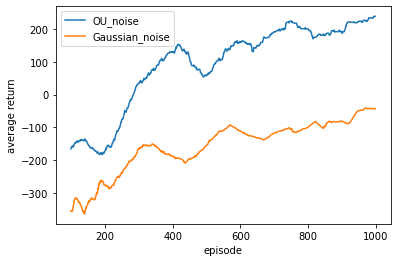

In [3]:
plt.plot(OU_noise['0'].rolling(100).mean(),label='OU_noise')
plt.plot(Gaussian_noise['0'].rolling(100).mean(),label='Gaussian_noise')
plt.legend()
plt.xlabel('episode')
plt.ylabel('average return')

In [3]:
import gym

In [5]:
env = gym.make("LunarLanderContinuous-v2")

In [7]:
env.reset()

array([ 0.00217943,  1.420184  ,  0.22073483,  0.41172412, -0.00251861,
       -0.04999975,  0.        ,  0.        ], dtype=float32)

In [10]:
a = env.action_space

In [19]:
env.step((0.5,0.5))

(array([ 0.00433798,  1.4294853 ,  0.21845524,  0.41338703, -0.00509453,
        -0.05152224,  0.        ,  0.        ], dtype=float32),
 -1.4528984071950561,
 False,
 {})

In [21]:
env

<TimeLimit<LunarLanderContinuous<LunarLanderContinuous-v2>>>